# Solução do Problema

## Qual é a distribuição das notas médias dos estabelecimentos?

In [0]:
%sql
SELECT
  stars,
  COUNT(*) AS qtd_estabelecimentos
FROM gold_dim_business
GROUP BY stars
ORDER BY stars

stars,qtd_estabelecimentos
1.0,1986
1.5,4932
2.0,9527
2.5,14316
3.0,18453
3.5,26519
4.0,31125
4.5,27181
5.0,16307


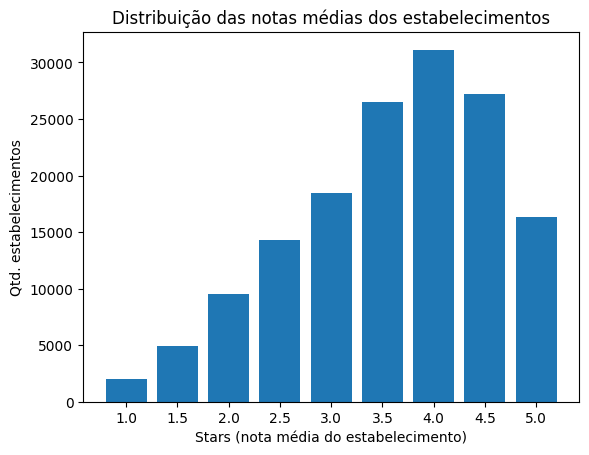

In [0]:
import matplotlib.pyplot as plt

df1 = spark.sql("""
SELECT stars, COUNT(*) AS qtd_estabelecimentos
FROM gold_dim_business
GROUP BY stars
ORDER BY stars
""").toPandas()

plt.figure()
plt.bar(df1["stars"].astype(str), df1["qtd_estabelecimentos"])
plt.xlabel("Stars (nota média do estabelecimento)")
plt.ylabel("Qtd. estabelecimentos")
plt.title("Distribuição das notas médias dos estabelecimentos")
plt.xticks(rotation=0)
plt.show()

A distribuição das notas médias dos estabelecimentos mostra uma concentração significativa em avaliações mais altas, especialmente entre 3.5 e 4.5 estrelas. O pico ocorre em 4.0 estrelas. 

Estabelecimentos com notas muito baixas entre 1.0 e 2.0, representam uma parte menor do conjunto de dados. 

Esse padrão sugere um viés positivo nas avaliações. Esse comportamento é comum em plataformas de avaliação, onde os usuários tendem a avaliar mais frequentemente os lugares que atenderam ou superaram suas expectativas. 

Além disso, avaliações extremas, especialmente 5.0 estrelas, aparecem em menor quantidade e isso pode refletir um critério mais rigoroso ou a necessidade de um maior número de avaliações para sustentar a nota máxima.

----

## Estabelecimentos com mais avaliações tendem a ter notas médias diferentes?

In [0]:
%sql
SELECT
  CASE
    WHEN review_count < 10 THEN 'Menos de 10'
    WHEN review_count BETWEEN 10 AND 50 THEN '10 a 50'
    WHEN review_count BETWEEN 51 AND 200 THEN '51 a 200'
    ELSE 'Mais de 200'
  END AS faixa_reviews,
  ROUND(AVG(stars), 2) AS media_stars,
  COUNT(*) AS qtd_estabelecimentos
FROM gold_dim_business
GROUP BY faixa_reviews
ORDER BY media_stars DESC

faixa_reviews,media_stars,qtd_estabelecimentos
Mais de 200,3.89,6196
51 a 200,3.68,22553
Menos de 10,3.61,51103
10 a 50,3.54,70494


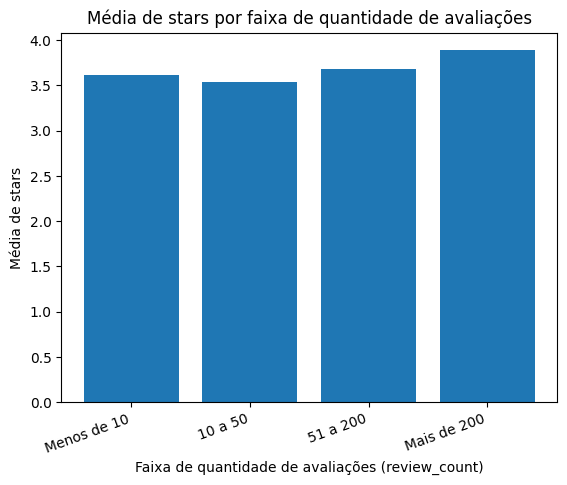

In [0]:
import pandas as pd
df2 = spark.sql("""
SELECT
  CASE
    WHEN review_count < 10 THEN 'Menos de 10'
    WHEN review_count BETWEEN 10 AND 50 THEN '10 a 50'
    WHEN review_count BETWEEN 51 AND 200 THEN '51 a 200'
    ELSE 'Mais de 200'
  END AS faixa_reviews,
  ROUND(AVG(stars), 2) AS media_stars,
  COUNT(*) AS qtd_estabelecimentos
FROM gold_dim_business
GROUP BY faixa_reviews
""").toPandas()

ordem = ["Menos de 10", "10 a 50", "51 a 200", "Mais de 200"]
df2["faixa_reviews"] = pd.Categorical(df2["faixa_reviews"], categories=ordem, ordered=True)
df2 = df2.sort_values("faixa_reviews")

plt.figure()
plt.bar(df2["faixa_reviews"], df2["media_stars"])
plt.xlabel("Faixa de quantidade de avaliações (review_count)")
plt.ylabel("Média de stars")
plt.title("Média de stars por faixa de quantidade de avaliações")
plt.xticks(rotation=20, ha="right")
plt.show()

Os resultados mostram que os estabelecimentos que recebem um maior número de avaliações costumam apresentar médias mais elevadas. Estabelecimentos que recebem mais de 200 avaliações possuem a maior média de pontuação (3,89). Entretanto, aqueles com um número de avaliações entre 10 e 50 apresentam a média mais baixa (3,54).

Isso pode indicar que estabelecimentos mais consolidados e com um maior número de avaliações acumuladas ao longo do tempo costumam proporcionar uma experiência mais padronizada aos clientes, resultando em avaliações médias mais altas ou até serem mais visitados que outros. 

E estabelecimentos com poucas avaliações podem exibir uma maior variabilidade nas notas, pois um número menor de reviews pode um impacto mais significativo na média final e também nas visitas de clientes que esperam algo bom.


--------------------

## Quais categorias de estabelecimentos apresentam as maiores notas médias?

In [0]:
%sql
SELECT
  categories,
  ROUND(AVG(stars), 2) AS media_stars,
  COUNT(*) AS qtd_estabelecimentos
FROM gold_dim_business
WHERE categories IS NOT NULL
GROUP BY categories
HAVING COUNT(*) > 50
ORDER BY media_stars DESC
LIMIT 10

categories,media_stars,qtd_estabelecimentos
"Health & Medical, Chiropractors",4.52,117
"Beauty & Spas, Tattoo",4.41,76
"Chiropractors, Health & Medical",4.41,121
"Caterers, Event Planning & Services",4.38,53
"Breweries, Food",4.37,54
"Food, Breweries",4.34,74
"Tattoo, Beauty & Spas",4.32,59
"Auto Repair, Automotive",4.29,351
"Home Services, Keys & Locksmiths",4.25,77
"Churches, Religious Organizations",4.25,77


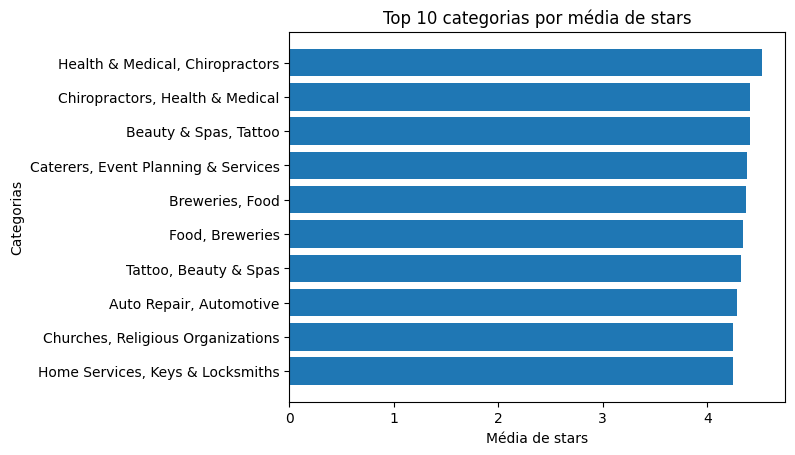

In [0]:
df3 = spark.sql("""
SELECT
  categories,
  ROUND(AVG(stars), 2) AS media_stars,
  COUNT(*) AS qtd_estabelecimentos
FROM gold_dim_business
WHERE categories IS NOT NULL
GROUP BY categories
HAVING COUNT(*) > 50
ORDER BY media_stars DESC
LIMIT 10
""").toPandas()
df3 = df3.sort_values("media_stars", ascending=True)
plt.figure()
plt.barh(df3["categories"], df3["media_stars"])
plt.xlabel("Média de stars")
plt.ylabel("Categorias")
plt.title("Top 10 categorias por média de stars")
plt.show()

As categorias de estabelecimentos que apresentam as maiores notas médias concentram-se majoritariamente em serviços especializados, como saúde, estética e bem-estar. Categorias como `Health & Medical, Chiropractors e Beauty & Spas` apresentam médias superiores a 4,4 estrelas, indicando um alto nível de satisfação dos usuários.

Esse padrão pode estar associado ao fato de que serviços especializados tendem a envolver interações mais personalizadas e expectativas mais bem definidas por parte dos clientes, o que pode resultar em avaliações mais positivas quando o serviço atende ao esperado.

Ressalta-se que a análise por categorias apresenta limitações metodológicas, uma vez que o campo `categories` não se encontra normalizado, contendo combinações de múltiplas categorias em formato textual. Dessa forma, categorias semanticamente equivalentes podem aparecer separadas devido à ordem ou composição dos termos, o que impacta a granularidade da análise.

A normalização das categorias foi identificada como uma melhoria possível para análises futuras, porém não foi implementada neste MVP para manter o escopo controlado e focado na construção do pipeline de dados.

--------

## Como se distribuem as notas individuais dadas pelos usuários?

In [0]:
%sql
SELECT
  review_stars,
  COUNT(*) AS qtd_reviews
FROM gold_fact_review
GROUP BY review_stars
ORDER BY review_stars

review_stars,qtd_reviews
1.0,449753
2.0,234820
3.0,301483
4.0,635419
5.0,1378525


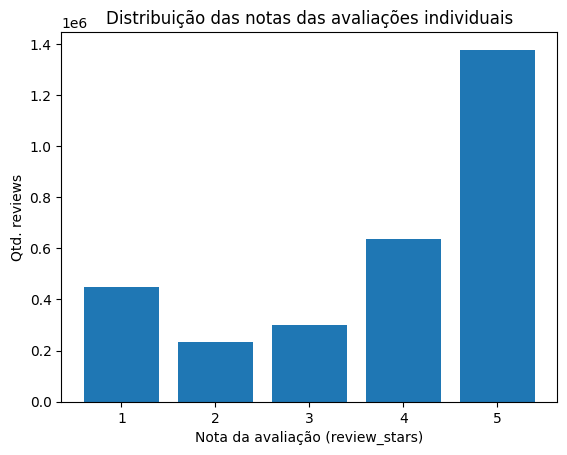

In [0]:
df4 = spark.sql("""
SELECT review_stars, COUNT(*) AS qtd_reviews
FROM gold_fact_review
GROUP BY review_stars
ORDER BY review_stars
""").toPandas()

plt.figure()
plt.bar(df4["review_stars"].astype(int).astype(str), df4["qtd_reviews"])
plt.xlabel("Nota da avaliação (review_stars)")
plt.ylabel("Qtd. reviews")
plt.title("Distribuição das notas das avaliações individuais")
plt.show()

A distribuição das avaliações individuais dos usuários apresenta forte concentração em notas mais altas, especialmente em avaliações de 5 estrelas, que representam a maior parcela do conjunto de dados. Avaliações de 4 estrelas também aparecem em volume significativo, enquanto notas intermediárias e baixas são menos frequentes.

Esse padrão indica um viés positivo comum em plataformas de avaliação, onde usuários tendem a registrar avaliações principalmente quando possuem experiências muito positivas ou muito negativas, sendo as avaliações extremamente positivas mais recorrentes. Esse comportamento deve ser considerado na interpretação das análises, uma vez que pode influenciar a média geral das notas dos estabelecimentos.

---


## Conclusão

As análises realizadas permitiram responder às perguntas propostas no objetivo do MVP, evidenciando padrões relevantes nas avaliações dos estabelecimentos da base. Observou-se uma predominância de avaliações positivas, tanto nas notas médias dos estabelecimentos quanto nas avaliações individuais, além de uma relação entre maior volume de reviews e maior estabilidade das notas médias.

As análises também evidenciaram limitações relacionadas à estrutura do campo de
categorias, que não se encontra normalizado, apontando oportunidades de melhoria para trabalhos futuros.

De forma geral, os resultados demonstram que o pipeline de dados construído é capaz de suportar análises analíticas consistentes em ambiente de dados em nuvem.
